## Goal

In this example, we would like to set up a boolean indicator that is based on whether all contributors to a thread belong to a well-connected group of contributors. We would like to generate two different metrics that let us measure this concept:

1. All of a thread's contributors are part of the [k-core](https://en.wikipedia.org/wiki/Degeneracy_%28graph_theory%29#k-Cores) of the co-contributor network. This means that for all contributors, ``degree(contributor_i) >= k``.
2. All contributors have commented on other threads: their out-degree in the commenter network is ``>=1``.

We would like to be able to generate different values for *k*, e.g., to fine-tune this parameter with machine learning.

## Defining the metrics

Every indicator is defined as a function that is decorated with the ``@metric`` decorator from ``pici.reporting``, receives a ``Community`` object as first parameter, and returns (by default) a dictionary of metric-name: metric-value items.

In [57]:
from pici.reporting import metric

# @metric(...)
# def my_indicator(community):
#   return {
#       'metric A': None
#   }

To correctly generate and combine the output of this indicator method, the decorator needs to be fed with information about the indicator's **level** of measurement, and what it returns (**returntype**).

Levels and returntypes are defined as constants in ``pici.datatypes``:

In [58]:
from pici.datatypes import CommunityDataLevel, MetricReturnType

print(CommunityDataLevel._member_names_)
print(MetricReturnType._member_names_)

['POSTS', 'TOPICS', 'CONTRIBUTORS', 'COMMUNITY']
['PLAIN', 'TABLE', 'DATAFRAME']


We would like to generate a boolean value for every thread and all of our metrics. Our indicator's level is therefore *TOPICS*, and our return type *DATAFRAME*. The indicator would have to look like this:

In [59]:
@metric(
    level=CommunityDataLevel.TOPICS,
    returntype=MetricReturnType.DATAFRAME
)
def all_well_connected(community):
    # use the community object to generate the metrics
    return {
        'all contributors in k-core': False,
        'all contributors out_degree >= 1': False
    }

To simplify the notation, there are shorthands for the common combinations of level and returntype. For example, ``@topics_metric`` would be the same as ``@metric(level=CommunityDataLevel.TOPICS, returntype=MetricReturnType.DATAFRAME)``:

In [60]:
from pici.reporting import topics_metric

@topics_metric
def all_well_connected(community):
    pass
    #...

We can use the community parameter to access the data that is required for measurement. In our case, we would like to access the threads (topics), the posts (to know which contributor posted in each thread), and the network. Our results should be Pandas.Series with indices that match that of the community's original topics DataFrame index.

**The complete indicator definition:**

In [61]:
import networkx as nx
from networkx.algorithms.approximation import clique
import pandas as pd
from pici.reporting import topics_metric

@topics_metric
def all_well_connected(community, k):
    """
    An indicator for whether all contributors to a thread
    are well-connected. There are two metrics for this concept,

    - ``all contributors in k-core`` - whether all contributors
       belong to the co-contributor network's k-core, and
    - ``all contributors out_degree >= 1`` - whether all
       contributors have commented on at least one thread that
       they did not start.

    Args:
        community: A pici.Community object
        k: parameter for k-core metric

    Returns:
        dict of (str, Pandas.Series)

    """

    # the easiest way to retain the topics index
    # is to define our metric on the posts df
    # and then aggregate to the topics level:

    # a) k-cores

    contributor_cores = nx.core_number(
        community.co_contributor_graph
    )

    # a df with one row per post, and True if contributor
    # belongs at least to k-core
    df = community.posts[[community.topic_column, community.contributor_column]]
    df['in_k_core'] = df[community.contributor_column].map(
        contributor_cores) >= k

    # aggregate to boolean topic-level metric,
    # rule: all(in_k_core)==True
    all_in_k_core = df.groupby(by=community.topic_column)['in_k_core'].agg(all)

    # b) have commented in other threads

    out_degree = community.commenter_graph.out_degree

    df['out_deg_lg_1'] = df[community.contributor_column].map(
        out_degree) >= 1
    all_commenters = df.groupby(by=community.topic_column)['out_deg_lg_1'].agg(all)

    return {
        f'all contributors in {k}-core': all_in_k_core,
        'all contributors out_degree >= 1': all_commenters
    }

## Using the indicator

To used this new indicator, it has to registered with the ``Pici`` toolbox object. We can then generate reports that include the indicator, or use it in a ML pipeline.

### Set up the toolbox

In [62]:
from pici import Pici

p = Pici(
    cache_dir='../../cache',
    # cache_nrows=5000,
    start='2017-01-01',
    end='2019-01-01',
)

### Register indicator

Simply add the indicator function to the metrics registry using ``Pici.add_metrics()``. We could also add metrics to individual communities, e.g. in cases where an indicator is defined using data that is not available in all communities.

In [63]:
p.add_metric(all_well_connected)

### Generate results

We can now use the metric in a report. We can pass different values for *k* to generate multiple metrics that each appear as one column in the report:

In [64]:
ks = [3,5,10,20]

rep = p.generate_report([
    (all_well_connected, {'k':k})
    for k in ks
]).results

In [65]:
rep

,all contributors in 5-core,community_name,all contributors in 10-core,all contributors in 20-core,all contributors in 3-core,all contributors out_degree >= 1
1-click-power-measurement-of-any-device-in-your-house,True,OpenEnergyMonitor,True,True,True,True
10000-kwh-ceiling-in-emoncms,True,OpenEnergyMonitor,True,False,True,True
100a-0-5v-dc-output-ct-interesting,False,OpenEnergyMonitor,False,False,True,True
120-volt-service-in-mexico,True,OpenEnergyMonitor,False,False,True,True
2-phase-whole-house-and-pv-monitoring-from-brazil,True,OpenEnergyMonitor,False,False,True,True
...,...,...,...,...,...,...
hello-all-you-do-goood-simon-from-thailand,False,PreciousPlastic,False,False,False,False
machines-built-in-brazil,True,PreciousPlastic,True,True,True,True
hello-anyone-from-brasil,False,PreciousPlastic,False,False,True,False
motor-for-shredder,True,PreciousPlastic,True,True,True,True


The report is a Pandas DataFrame that can be used for further analyses and visualization:

[Text(0.5, 1.0, 'share of threads where all contributors are part of the k-core of the co-contributor network')]

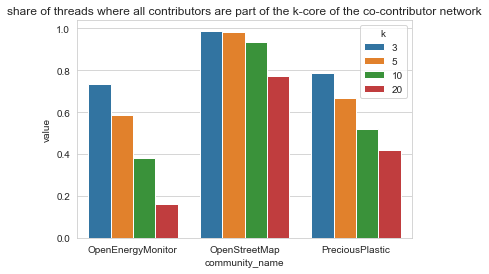

In [66]:
import seaborn as sns

id_col = 'community_name'
df = rep.rename(columns={
    f'all contributors in {k}-core': k for k in ks
})
df = df.groupby(by='community_name').mean().reset_index()[
    [id_col] + ks
]
df = pd.melt(df, id_vars=[id_col], value_vars=ks, var_name='k')

sns.barplot(x=id_col, y='value', hue='k', data=df).set(title="share of threads where all contributors are part of the k-core of the co-contributor network")

[Text(0.5, 1.0, 'share of threads where all contributors are also commenters on other threads')]

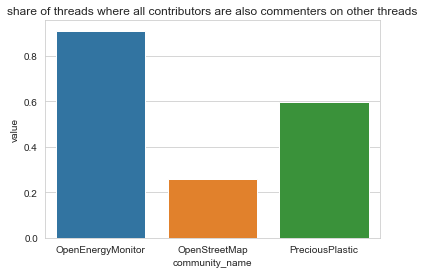

In [67]:
metric_cols_commenters = ['all contributors out_degree >= 1']
percent_commenters = pd.melt(rep.groupby(by='community_name').mean().reset_index()[
                                       [id_col] + metric_cols_commenters
                                       ],id_vars=[id_col], value_vars=metric_cols_commenters)

sns.barplot(x='community_name', y='value', data=percent_commenters).set(title="share of threads where all contributors are also commenters on other threads")

We can also use the indicator and its parameter in a sklearn pipeline (e.g., to find an optimal value for *k* by adding a classifier and cross-validation).

In [68]:
pipe = p.pipelines.topics(parameters={
    'all_well_connected': {'k': 10}
})

In [69]:
pipe.transform(p.communities)

,,all contributors in 10-core,all contributors out_degree >= 1,number of posts,number of contributors,first post date,second post date,last post date,delay first last post,delay first second post
topic_slug,community_name,,,,,,,,,
1-click-power-measurement-of-any-device-in-your-house,OpenEnergyMonitor,True,True,3,2,2017-02-09 00:00:00,2017-02-09 00:00:00,2017-02-09 00:00:00,0,0
10000-kwh-ceiling-in-emoncms,OpenEnergyMonitor,True,True,11,4,2017-04-17 00:00:00,2017-04-17 00:00:00,2017-04-20 00:00:00,3,0
100a-0-5v-dc-output-ct-interesting,OpenEnergyMonitor,False,True,2,2,2018-08-26 00:00:00,2018-08-26 00:00:00,2018-08-26 00:00:00,0,0
120-volt-service-in-mexico,OpenEnergyMonitor,False,True,3,3,2017-06-08 00:00:00,2017-06-08 00:00:00,2017-06-09 00:00:00,1,0
2-phase-whole-house-and-pv-monitoring-from-brazil,OpenEnergyMonitor,False,True,11,4,2017-09-13 00:00:00,2017-09-13 00:00:00,2017-09-15 00:00:00,2,0
...,...,...,...,...,...,...,...,...,...,...
zagreb-cooperative-space,PreciousPlastic,False,True,1,1,2018-12-26 18:24:00,2018-12-26 18:24:00,2018-12-26 18:24:00,0,0
zelenew-basket-extrusion-v4,PreciousPlastic,True,True,3,3,2018-06-12 13:24:00,2018-11-28 00:01:00,2018-12-13 07:35:00,183,168
zelenew_sorting-tray,PreciousPlastic,False,True,1,1,2017-02-03 02:54:00,2017-02-03 02:54:00,2017-02-03 02:54:00,0,0


**Note:** *Reports and pipelines are two ways of generating indicator values in PICI. Generally, pipelines should generate results faster, as the sklearn implementation can parallelize calculation per indicator and community.*